In [1]:
#nu, a constant dependant on EOS, that affects a.
def nu_(EOS):
    if EOS == 'SRK':
        O1 = 0.42748
        O2 = 0.08664
        return [O1, O2]
    if EOS == 'PR':
        O1 = 0.45724
        O2 = 0.07780
        return [O1, O2] 

In [2]:
#D1, a parameter that defines the EOS.
def d_1(EOS):
    import jax.numpy as jnp
    if EOS == 'SRK':
        u0 = 1
        w0 = 0
    if EOS == 'PR':
        u0 = 2
        w0 = -1      
    D1 = (u0 + jnp.sqrt(u0**2-4*w0))/2
    return D1

#D2, a parameter that defines the EOS.
def d_2(EOS):
    import jax.numpy as jnp  
    if EOS == 'SRK':
        u0 = 1
        w0 = 0
    if EOS == 'PR':
        u0 = 2
        w0 = -1      
    D2 = (u0 - jnp.sqrt(u0**2-4*w0))/2
    return D2

def d_3(D1, D2):
    return D1+D2
def d_4(D1, D2):
    return(D1*D2)

In [3]:
#m, the accentricity polynomial.
def m_(w, C, EOS):
    import jax.numpy as jnp
    
    m = jnp.zeros([C])
    if EOS == 'SRK':
        m = m.at[:].set(0.48+1.574*w-0.176*w**2)
        return m
    if EOS == 'PR':
        m = m.at[:].set(0.37464+1.54226*w-0.26992*w**2)
        return m

In [4]:
#ai, the attraction paramater of each component i.
def a_i(T, M, NU, Tc, Pc, R, C):
    import jax.numpy as jnp
    ai = jnp.zeros([C])
    for i in range(C):
        ai = ai.at[i].set((R*Tc[i])**2*NU[0]/Pc[i]*(1 + M[i]*(1-(T/Tc[i])**0.5))**2)
    return ai

In [5]:
#aij, the binary attraction paramater of component system i-j.
def a_ij(ai, C, k):
    import jax.numpy as jnp
    aij = jnp.zeros([C, C])
    for i in range(C):
        for j in range(C):
            aij = aij.at[i,j].set((ai[i]*ai[j])**0.5*(1-k[i][j]))
    return aij

In [6]:
#bi, the repulsion paramater of each component i.
def b_i(NU, Tc, Pc, R, C):
    import jax.numpy as jnp
    bi = jnp.zeros([C])
    for i in range(C):
        bi = bi.at[i].set(NU[1]*R*Tc[i]/Pc[i])
    return bi

In [7]:
#a_tot, the weighted sum of binary attraction interactions.
def a_t(y, aij, C):
    import jax.numpy as jnp
    import jax
    a = jnp.array(0)
    
    yn = jnp.append(y[:-1], (1-jnp.sum(y[:-1])))
    
    r = C-1
    for i in range(C):
        for j in range(C):
            a += jnp.multiply(jnp.multiply(yn[i],aij[i,j]), yn[j])
    return a

In [8]:
#b_tot, the weighted sum of repulsion interactions.
def b_t(y, bi, C):
    import jax.numpy as jnp
    import jax
    bt = jnp.array(0)
    r = C-1
    for i in range(C):
        bt += y[i]*(bi[i]-bi[r])
    bt += bi[r]
    return bt

In [9]:
def A_dim(a, P, R, T):
    import jax.numpy as jnp
    return a*P/(R*T)**2

In [10]:
def ALPHA_(y, aij, a, C):
    import jax.numpy as jnp
    import jax
    
    yn = jnp.append(y[:-1], (1-jnp.sum(y[:-1])))
    ALPHA = jnp.zeros(C)
    for i in range(C):
        for k in range(C):
                ALPHA  = ALPHA.at[i].add(yn[k]*aij[k, i])
    
    ALPHA = ALPHA.at[:].set(ALPHA[:]/a)
    
    return ALPHA

In [11]:
def BETA_(bi, b, C):
    BETA = bi/b
    return BETA

In [12]:
def B_dim(b, P, R, T):
    import jax.numpy as jnp
    return b*P/(R*T)

In [13]:
def CompFact(A, B, EOS):
    import jax.numpy as jnp
    import jax
    #EOS cubic compressbility coefficients
    D1 = d_1(EOS)
    D2 = d_2(EOS)
    D3 = d_3(D1, D2)
    D4 = d_4(D1, D2)
    
    c1 = jnp.array(1)
    c2 = jnp.array((D3-1)*B-1)
    c3 = jnp.array(A-D3*B-(D3-D4)*B**2)
    c4 = jnp.array(-D4*(B**3+B**2)-A*B)
    
    
    #Cubic discriminant
    disc = 18*c1*c2*c3*c4 - 4*c2**3*c4 + c2**2*c3**2 - 4*c1*c3**3 - 27*c1**2*c4**2
    def threeroot(c1, c2, c3, c4, disc):
        #Three Real Roots
        def three_distinct(c1, c2, c3, c4):
            p1 = (3*c1*c3 - c2**2)/(3*c1**2)
            p2 = (2*c2**3 - 9*c1*c2*c3 + 27*c1**2*c4)/(27*c1**3)
            arg = 3*p2/(2*p1)*jnp.sqrt(-3/p1)
            arg = jax.lax.complex(arg, jnp.array(0.0))

            Z1 = 2*(-p1/3)**(1/2)*jnp.cos(jnp.arccos(arg)/3)
            Z2 = 2*(-p1/3)**(1/2)*jnp.cos(jnp.arccos(arg)/3-2*jnp.pi/3)
            Z3 = 2*(-p1/3)**(1/2)*jnp.cos(jnp.arccos(arg)/3-4*jnp.pi/3)

            Z1 = jnp.real(Z1 - c2/(3*c1))
            Z2 = jnp.real(Z2 - c2/(3*c1))
            Z3 = jnp.real(Z3 - c2/(3*c1))
            return jnp.maximum(jnp.maximum(Z1, Z2), Z3)
        
        def repeated_root(c1, c2, c3, c4): 
            def one_repeated(c1, c2, c3, c4):
                #Double multiplicity root
                Z1 = (4*c1*c2*c3-9*c1**2*c4-c2**3)/(c1*(c2**2-3*c1*c3))
                Z2 = (9*c1*c4-c2*c3)/(2*(c2**2-3*c1*c3))
                return jnp.maximum(Z1, Z2)
            def two_repeated(c1, c2, c3, c4):
                #Triple multiplicity root
                Z3 = -c2/3*c1
                return Z3
            return jax.lax.cond(c2**2 == 3*c1*c3, two_repeated, one_repeated, c1, c2, c3, c4)
    
        return jax.lax.cond(disc != 0, three_distinct, repeated_root, c1, c2, c3, c4)
    
    def oneroot(c1, c2, c3, c4, disc):
        #One Real Root, Two Complex Conjugates
        
        d0 = c2**2 - 3*c1*c3
        d1 = 2*c2**3 - 9*c1*c2*c3 + 27*c1**2*c4
        
        C0 = jnp.cbrt((d1 + jnp.sqrt(d1**2-4*d0**3))/2)
        #Select other root if needed
        def proot(d1, d0):
            C = jnp.cbrt((d1 + jnp.sqrt(d1**2-4*d0**3))/2)
            return C
        def nroot(d1, d0):
            C = jnp.cbrt((d1 - jnp.sqrt(d1**2-4*d0**3))/2)
            return C
        
        C = jax.lax.cond(C0 == 0, nroot, proot, d1, d0)

        Z1 = -1/(3*c1)*(c2+C+d0/C)
        
        return Z1
    
    return jax.lax.cond(disc >= 0, threeroot, oneroot, c1, c2, c3, c4, disc)

In [14]:
def EOS_Params(y, T, P, Tc, Pc, w, k, R, C, EOS):
    nu = nu_(EOS)
    m = m_(w, C, EOS)
    d1 = d_1(EOS)
    d2 = d_2(EOS)
    
    ai = a_i(T, m, nu, Tc, Pc, R, C)
    aij = a_ij(ai, C, k)
    a = a_t(y, aij, C)
    bi = b_i(nu, Tc, Pc, R, C)
    b = b_t(y, bi, C)
    
    
    A = A_dim(a, P, R, T)
    B = B_dim(b, P, R, T)
    
    
    
    Z = CompFact(A, B, EOS)
    
    ALPHA = ALPHA_(y, aij, a, C)
    BETA = BETA_(bi, b, C)
    return ai, aij, a, bi, b, A, B, d1, d2, Z, ALPHA, BETA

In [15]:
#ln(f/xP) the chemical potential departure for component i.
def lnfc(ai, aij, a, bi, b, A, B, d1, d2, Z, ALPHA, BETA, C):
    import jax
    import jax.numpy as jnp
    
    
    
    lnfc = jnp.zeros(C)
    E0 = jnp.log((Z+d1*B)/(Z+d2*B))
    E1 = BETA*(Z-1)
    E2 = -jnp.log(Z-B)
    E3 = -2*(A/B)*ALPHA/(d1-d2)*E0
    E4 = (A/B)*BETA/(d1-d2)*E0
    lnfci = E1+E2+E3+E4 
    lnfc = lnfc.at[:].set(lnfci)
        
    return lnfc

In [16]:
def dlnfc(ai, aij, a, bi, b, A, B, d1, d2, Z, ALPHA, BETA, C):
    import jax
    import jax.numpy as jnp
    r = C-1
    dlnfc = jnp.zeros([C, C])
    for i in range(C):
        for j in range(C):
            d_Z0 = -B/((3*Z**2+2*(B-1)*Z)+(A-2*B-3*B**2)) 
            d_Z1 = 2*(Z-B)*(A/B)*(ALPHA[j]-ALPHA[r])
            d_Z2 = (Z**2-(2+6*B)*Z+3*B**2+2*B-A)*(BETA[j]-BETA[r])
            dZ = d_Z0*(d_Z1+d_Z2)
            
            
            dABA = A/B*((aij[i][j]-aij[i][r])/a - (BETA[j]-BETA[r])*ALPHA[i])
            dE0 = (dZ+d1*B*(BETA[j]-BETA[r]))/(Z+d1*B) - (dZ+d2*B*(BETA[j]-BETA[r]))/(Z+d2*B)
            dAbB = 2*A/(b*B)*(ALPHA[j]-ALPHA[r]-BETA[j]+BETA[r])

            E0 = jnp.log((Z+d1*B)/(Z+d2*B))
            E1 = BETA[i]*(dZ - (Z-1)*(BETA[j]-BETA[r]))
            E2 = (dZ - B*(BETA[j]-BETA[r]))/(B-Z)
            E3 = -(A/B*dE0*ALPHA[i] + E0*dABA)/jnp.sqrt(2)
            E4 = BETA[i]/jnp.sqrt(8)*(A/B*dE0 + E0*dAbB*b)
            
            
            dlnfc = dlnfc.at[i, j].set(E1+E2+E3+E4)
    
    return dlnfc

In [17]:
def ChemicalPotential(y, T, P, Tc, Pc, w, k, R, C, EOS):
    import jax
    import jax.numpy as jnp
    

    ai, aij, a, bi, b, A, B, d1, d2, Z, ALPHA, BETA = EOS_Params(y, T, P, Tc, Pc, w, k, R, C, EOS)
    lnf = lnfc(ai, aij, a, bi, b, A, B, d1, d2, Z, ALPHA, BETA, C)
    dlnf = dlnfc(ai, aij, a, bi, b, A, B, d1, d2, Z, ALPHA, BETA, C)
    
    r = C-1
    dmu = jnp.zeros([C, C])
    for i in range(C):
        for j in range(C):
            if i != j:
                if i != r:
                    dmuij = dlnf[i, j]*R*T
                elif i == r:
                    dmuij = (dlnf[r, j] - 1/y[r])*R*T
            else:
                dmuij = (dlnf[j, j] + 1/y[j])*R*T
            
            dmu = dmu.at[i, j].set(dmuij)
    return dmu

In [18]:
def GeneralizedCubicHessian(y, yr, T, P, Tc, Pc, w, k, R, C, EOS):
    import jax.numpy as jnp
    dmu = ChemicalPotential(jnp.append(y, yr), T, P, Tc, Pc, w, k, R, C, EOS)

    r = C-1
    H = jnp.zeros([r, r])
    
    for i in range(r):
        for j in range(r):
            Hij = dmu[i, j]-dmu[r, j]
            H = H.at[i, j].set(Hij)
    return H

In [19]:
def l_min(H):
    import jax.numpy as jnp
    import jax
    
    #Inverse power iteration
    H_inv = jnp.linalg.inv(H)
    umin = jnp.ones(len(H))
    umin = umin/jnp.linalg.norm(umin)
    for t in range(50):
        umin = jnp.dot(H_inv, umin)
        umin = umin/jnp.linalg.norm(umin)
    
    l = jnp.dot(jnp.dot(H, umin), umin)
    return l, umin

In [20]:
def CostFunction(y, T, P, Tc, Pc, w, k, R, C, EOS):
    import jax
    import jax.numpy as jnp
    yr = y[-1]
    y = y[0:-1]
    Hf = jax.jit(GeneralizedCubicHessian, static_argnames=['C', 'R', 'EOS'])
    H = Hf(y, yr, T, P, Tc, Pc, w, k, R, C, EOS)
    lmin = jax.jit(l_min)
    l, u = lmin(H)
    
    Q = l**2
    
    dHf = jax.jacfwd(Hf, argnums = 0)
    dH = dHf(y, yr, T, P, Tc, Pc, w, k, R, C, EOS)
    C = jnp.dot(jnp.dot(jnp.dot(dH, u), u), u)**2
    
    return C,Q

In [21]:
def CalcRho(y, T, P, Tc, Pc, w, k, R, C, EOS):
    import jax
    import jax.numpy as jnp
    ai, aij, a, bi, b, A, B, d1, d2, Z, ALPHA, BETA = EOS_Params(y, T, P, Tc, Pc, w, k, R, C, EOS)
    rho = P/(Z*R*T)    
    return rho

In [25]:
import jax.numpy as jnp
import KeyFunctions as me
import matplotlib.pyplot as plt
import jax
import numpy as np
import scipy as sp 
import scipy.constants as spc 
jax.config.update("jax_enable_x64", True)
from IPython.display import clear_output

import matplotlib as mlp
import matplotlib.pyplot as plt
mlp.rcParams['font.family'] = 'Nimbus Roman'
mlp.rcParams['figure.dpi']= 300
mlp.rcParams['axes.linewidth'] = 1.5
mlp.rcParams['ytick.major.width'] = 1
mlp.rcParams['xtick.major.width'] = 1

EOS = 'SRK'
DataSet = 'DimJiaLi Unique'
MxN = 5
#[y, Tc, Pc, w, C, R, Vc, k, mxNames] = me.LookUpMix(MxN, DataSet, EOS)

R = spc.R
y = jnp.array([3.5698235e-03, 4.5274937e-05, 9.9638492e-01, 9.9999999e-09])
Tc = jnp.array([1135.6097,  886.2297, 1059.598,   126.193 ])
Pc = jnp.array([6524966.5, 6428250.,  2048236.1, 3397800. ])
w = jnp.array([0.44470918, 0.5198756,  1.087389,   0.04      ])
C = len(y)
k = jnp.array([[0.        , 0.13649112, 0.13422936, 0.1318534 ],[0.13649112, 0.        , 0.13311332, 0.13316971],[0.13422936, 0.13311332, 0.        , 0.12300295],[0.1318534 , 0.13316971, 0.12300295, 0.        ]])

In [26]:
T = np.linspace(300, 400, 100)
P = np.linspace(6e6, 8e6, 200)

F1 = np.zeros([len(P), len(T)])
F2 = np.zeros([len(P), len(T)])
for i in range(len(T)):
    for j in range(len(P)):
        F1[j,i], F2[j,i] = CostFunction(y, T[i], P[j], Tc, Pc, w, k, R, C, EOS)
        
F = F1+F2

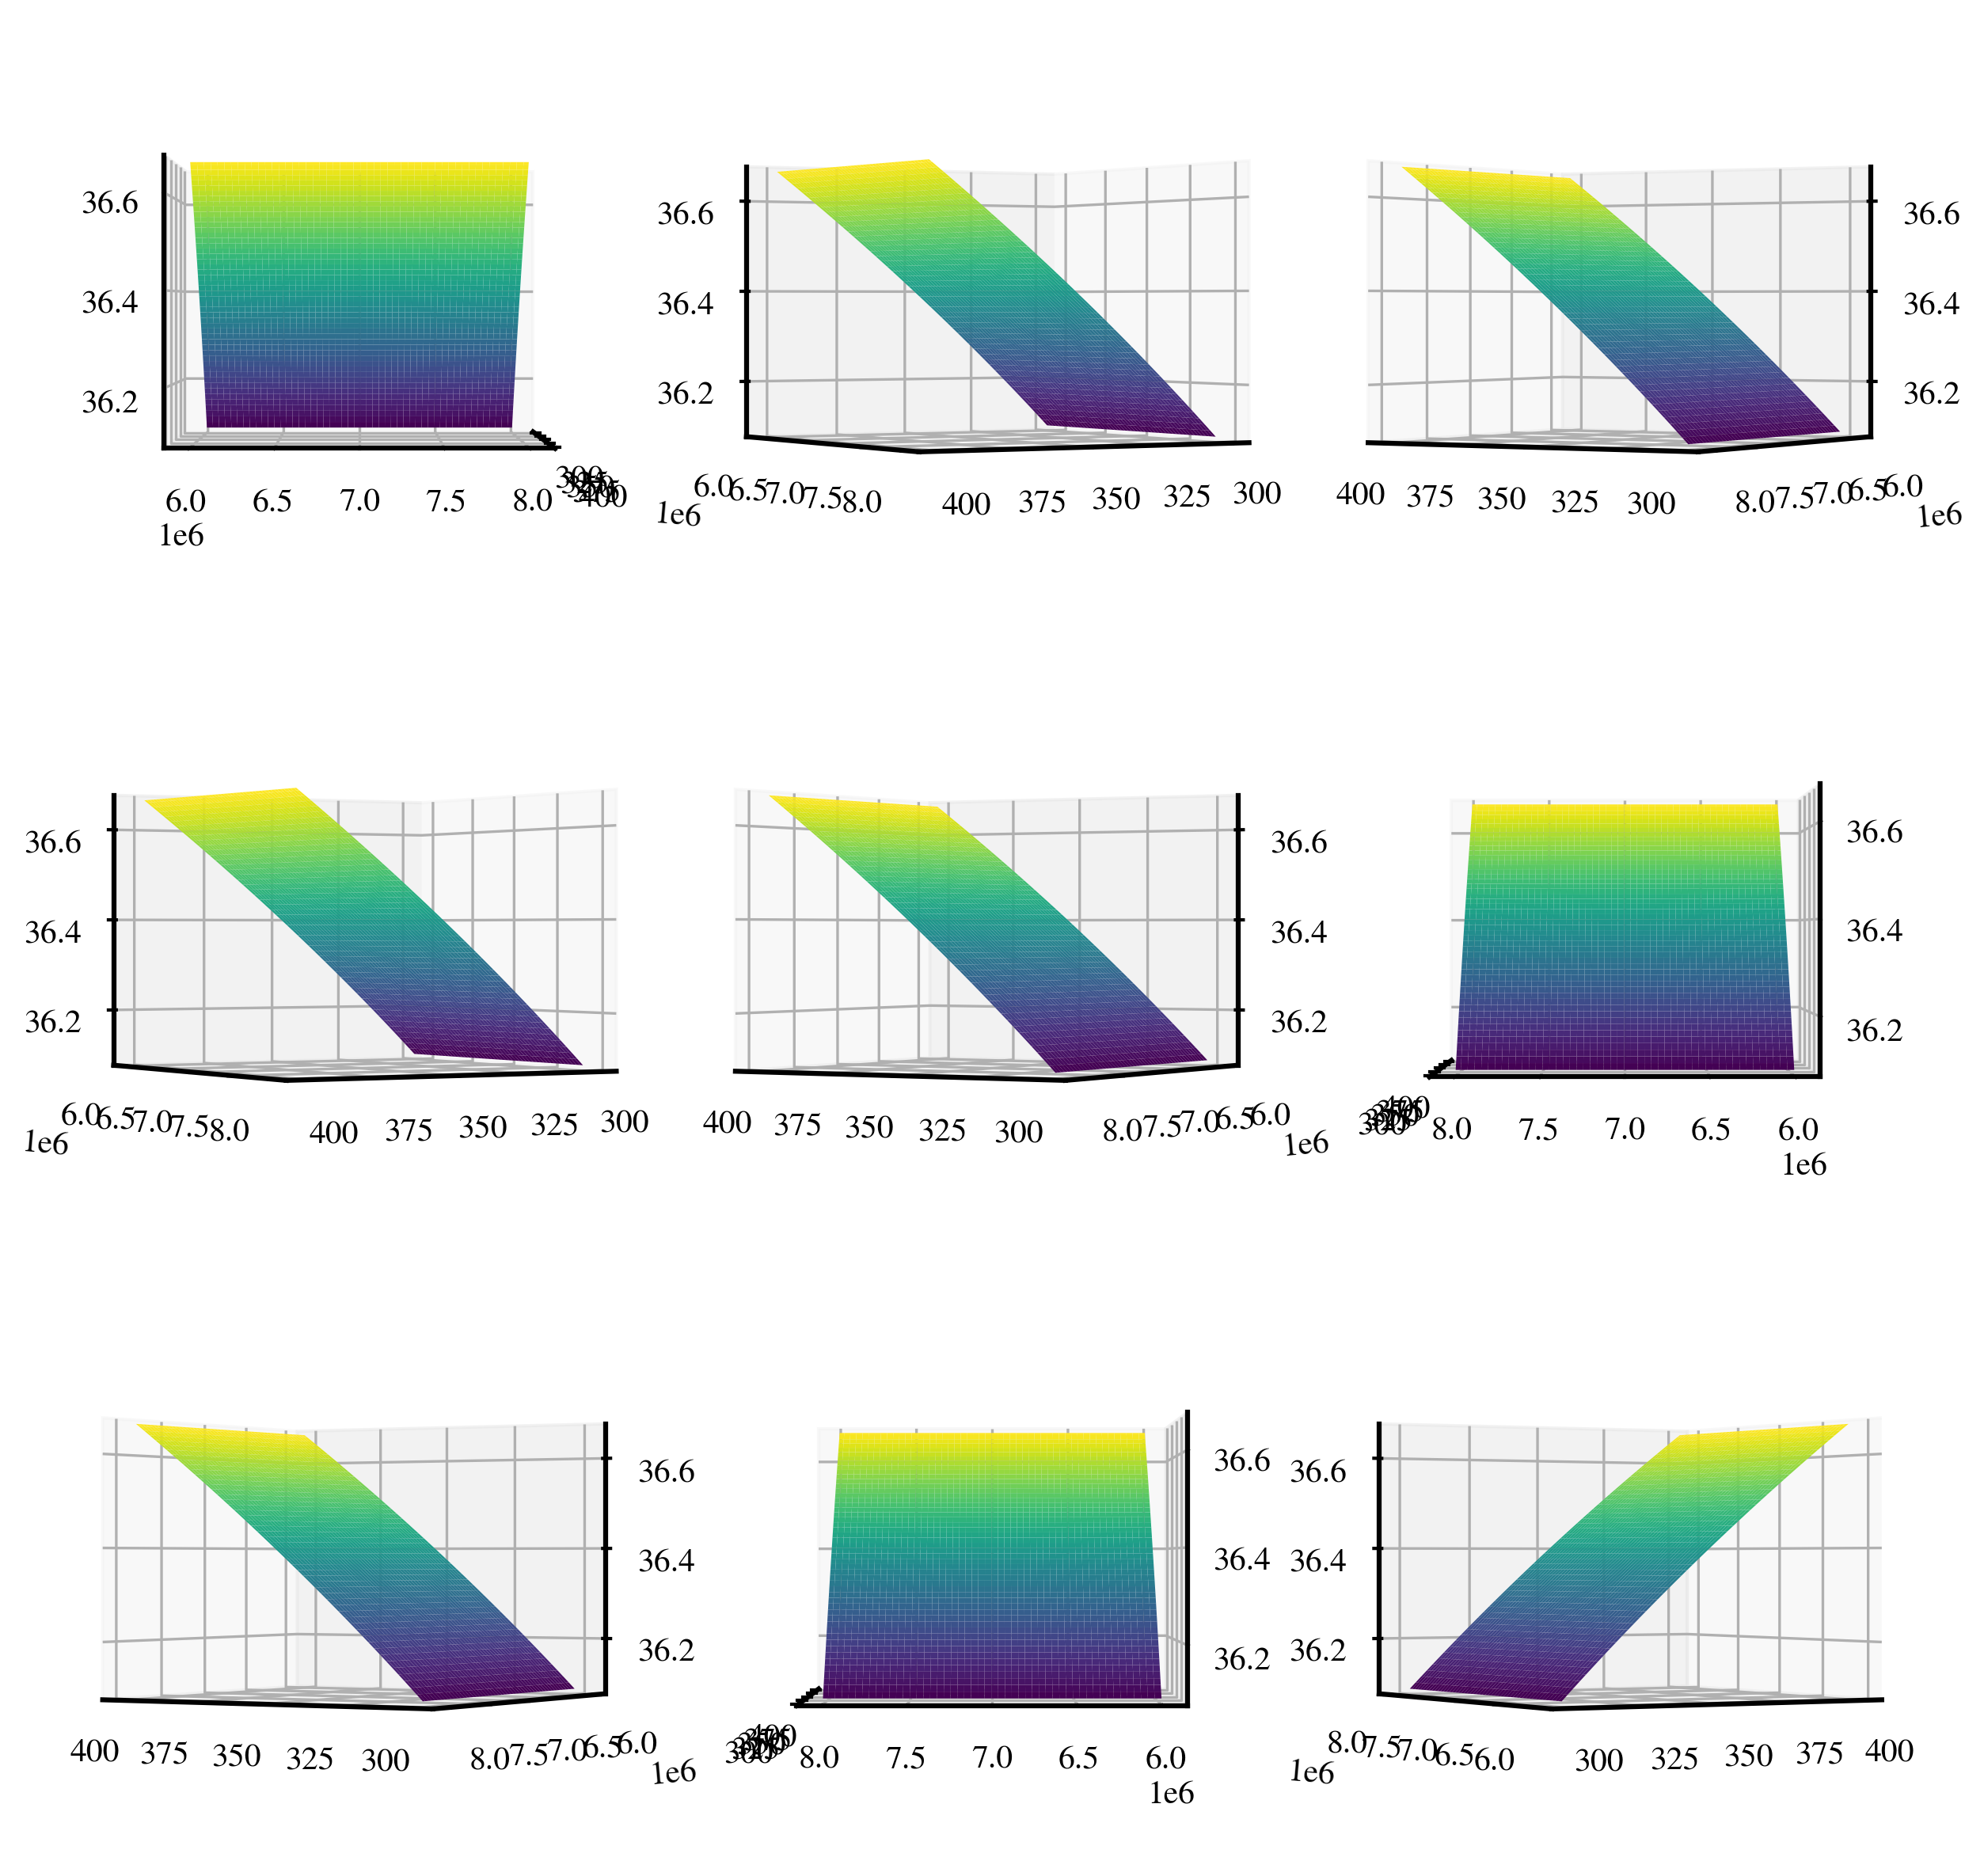

In [27]:
TT, PP = np.meshgrid(T, P)
fig, ax = plt.subplots(3, 3, subplot_kw={"projection": "3d"}, figsize = [10, 10])
fig.subplots_adjust(wspace=0.1, hspace=0.1)


for i in range(3):
    for j in range(3):
        ax[i, j].plot_surface(TT, PP, jnp.log(F), cmap = 'viridis')
        ax[i, j].view_init(0, 60*(i+j))
        #ax[i, j].set_zlim([22.5, 23.5])

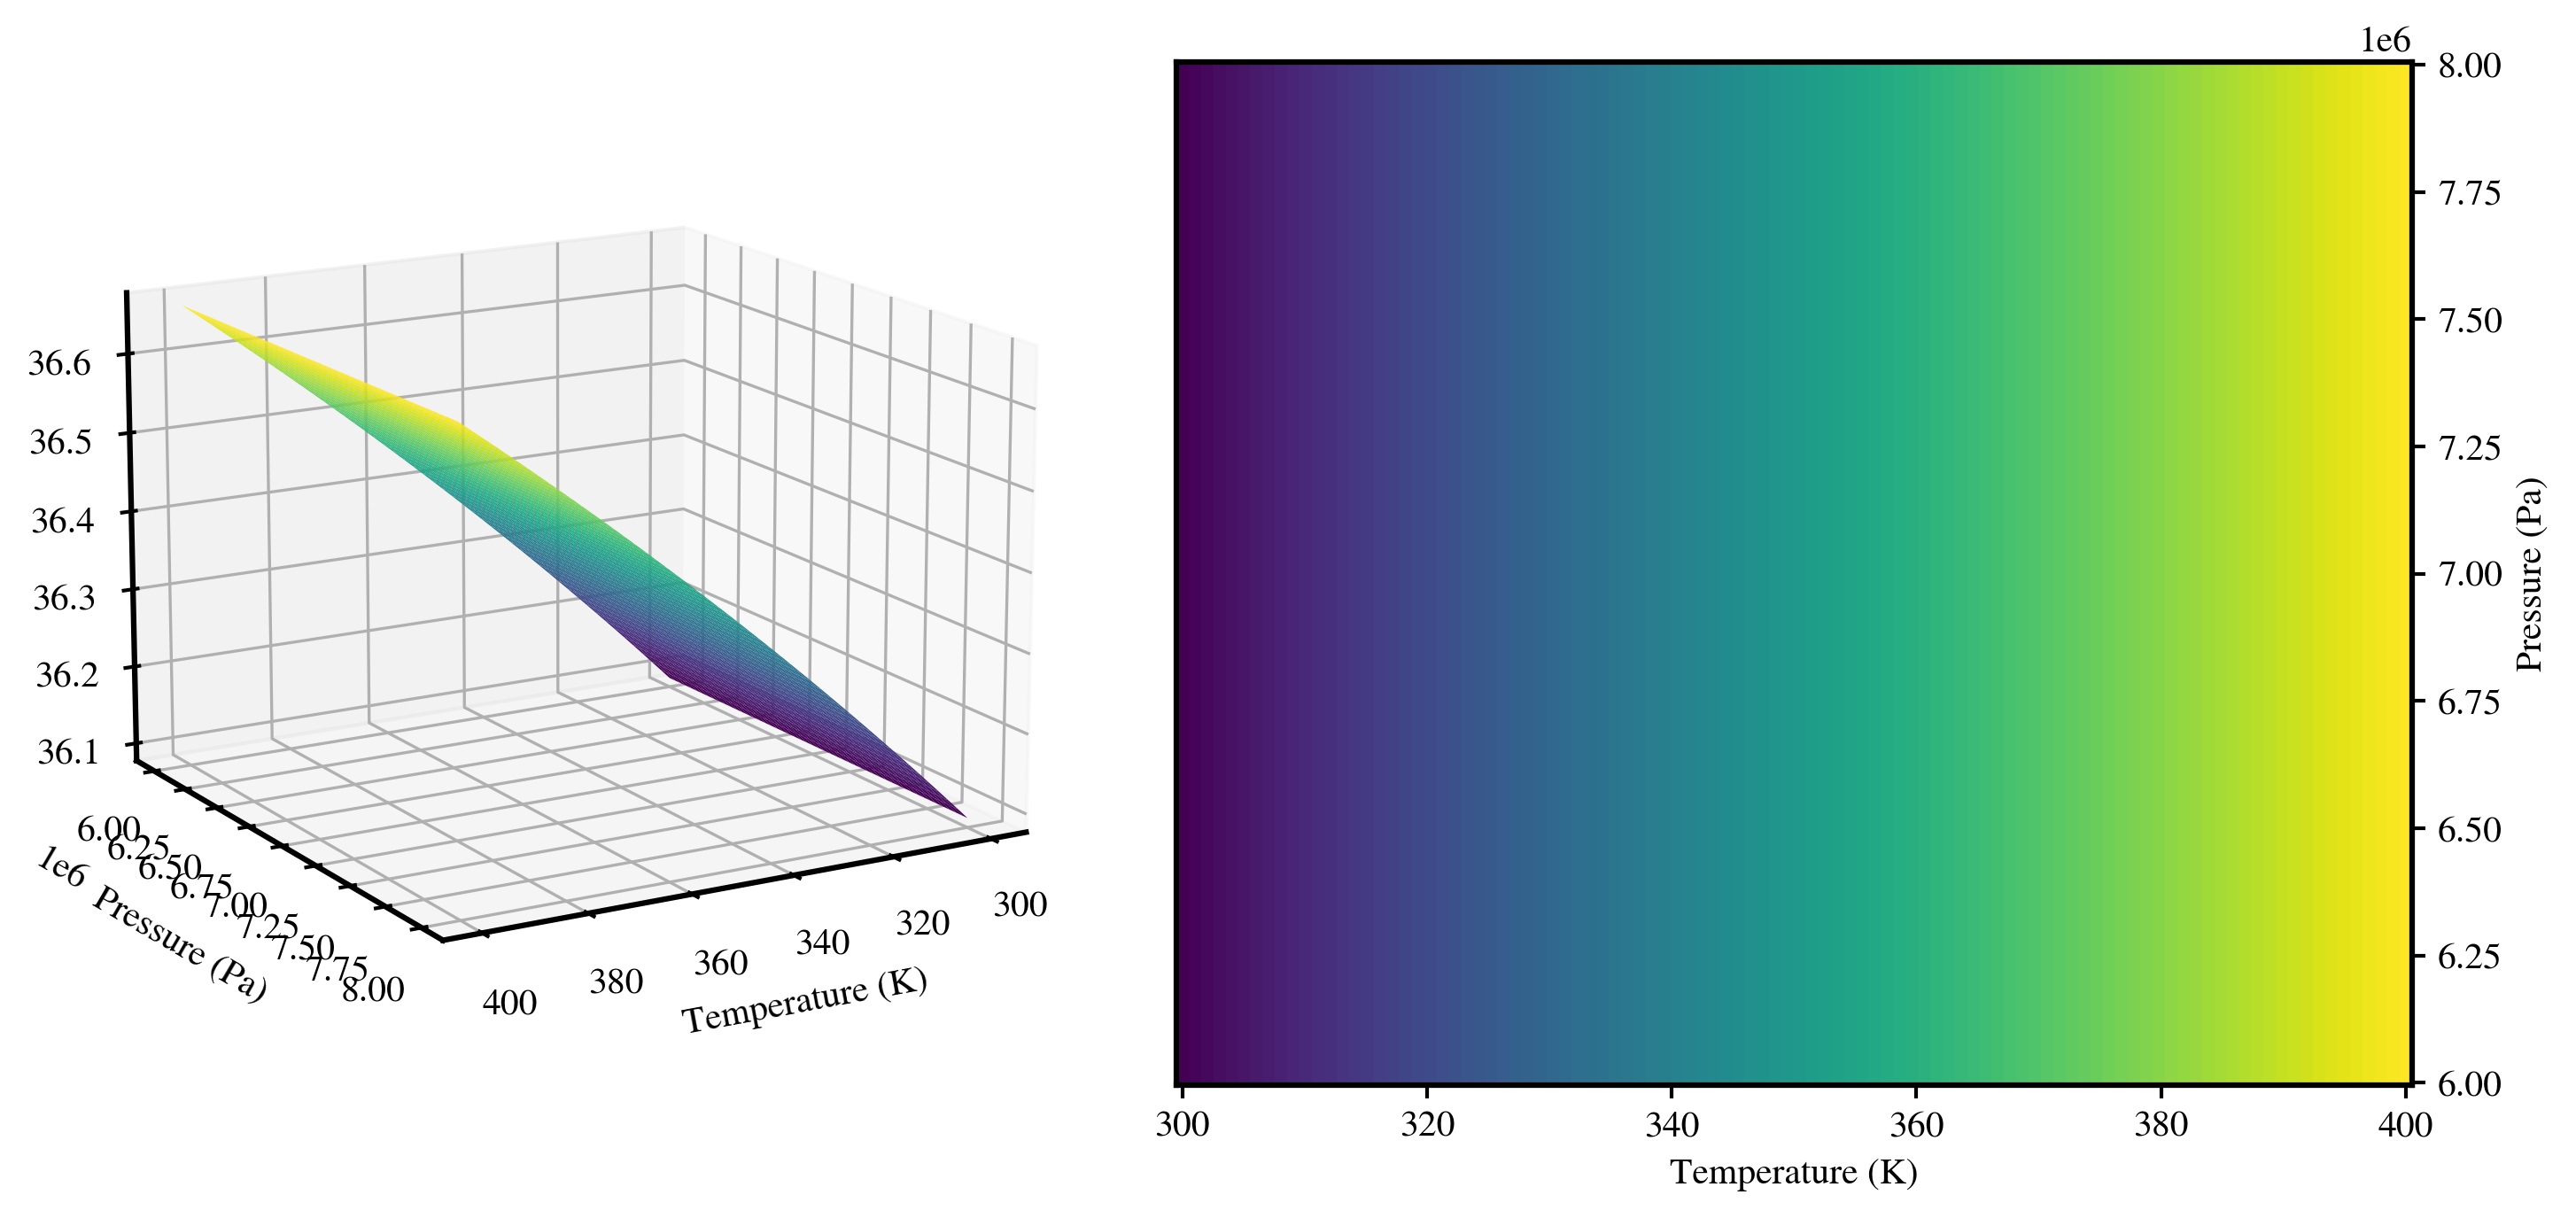

In [28]:
import matplotlib.colors as clrs

fig = plt.figure(figsize = [12, 5])
ax1 = fig.add_subplot(1, 2, 1, projection= "3d")
ax1.plot_surface(TT, PP, jnp.log(F), cmap = 'viridis')
ax1.set_xlabel("Temperature (K)")
ax1.set_ylabel("Pressure (Pa)")
#ax1.set_zlim([15, 30])
ax1.view_init(15, 60)

ax2 = fig.add_subplot(1, 2, 2)
ax2.pcolormesh(T, P, jnp.log(F))
ax2.set_xlabel("Temperature (K)")
ax2.set_ylabel("Pressure (Pa)")
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()

plt.subplots_adjust(wspace = 0)

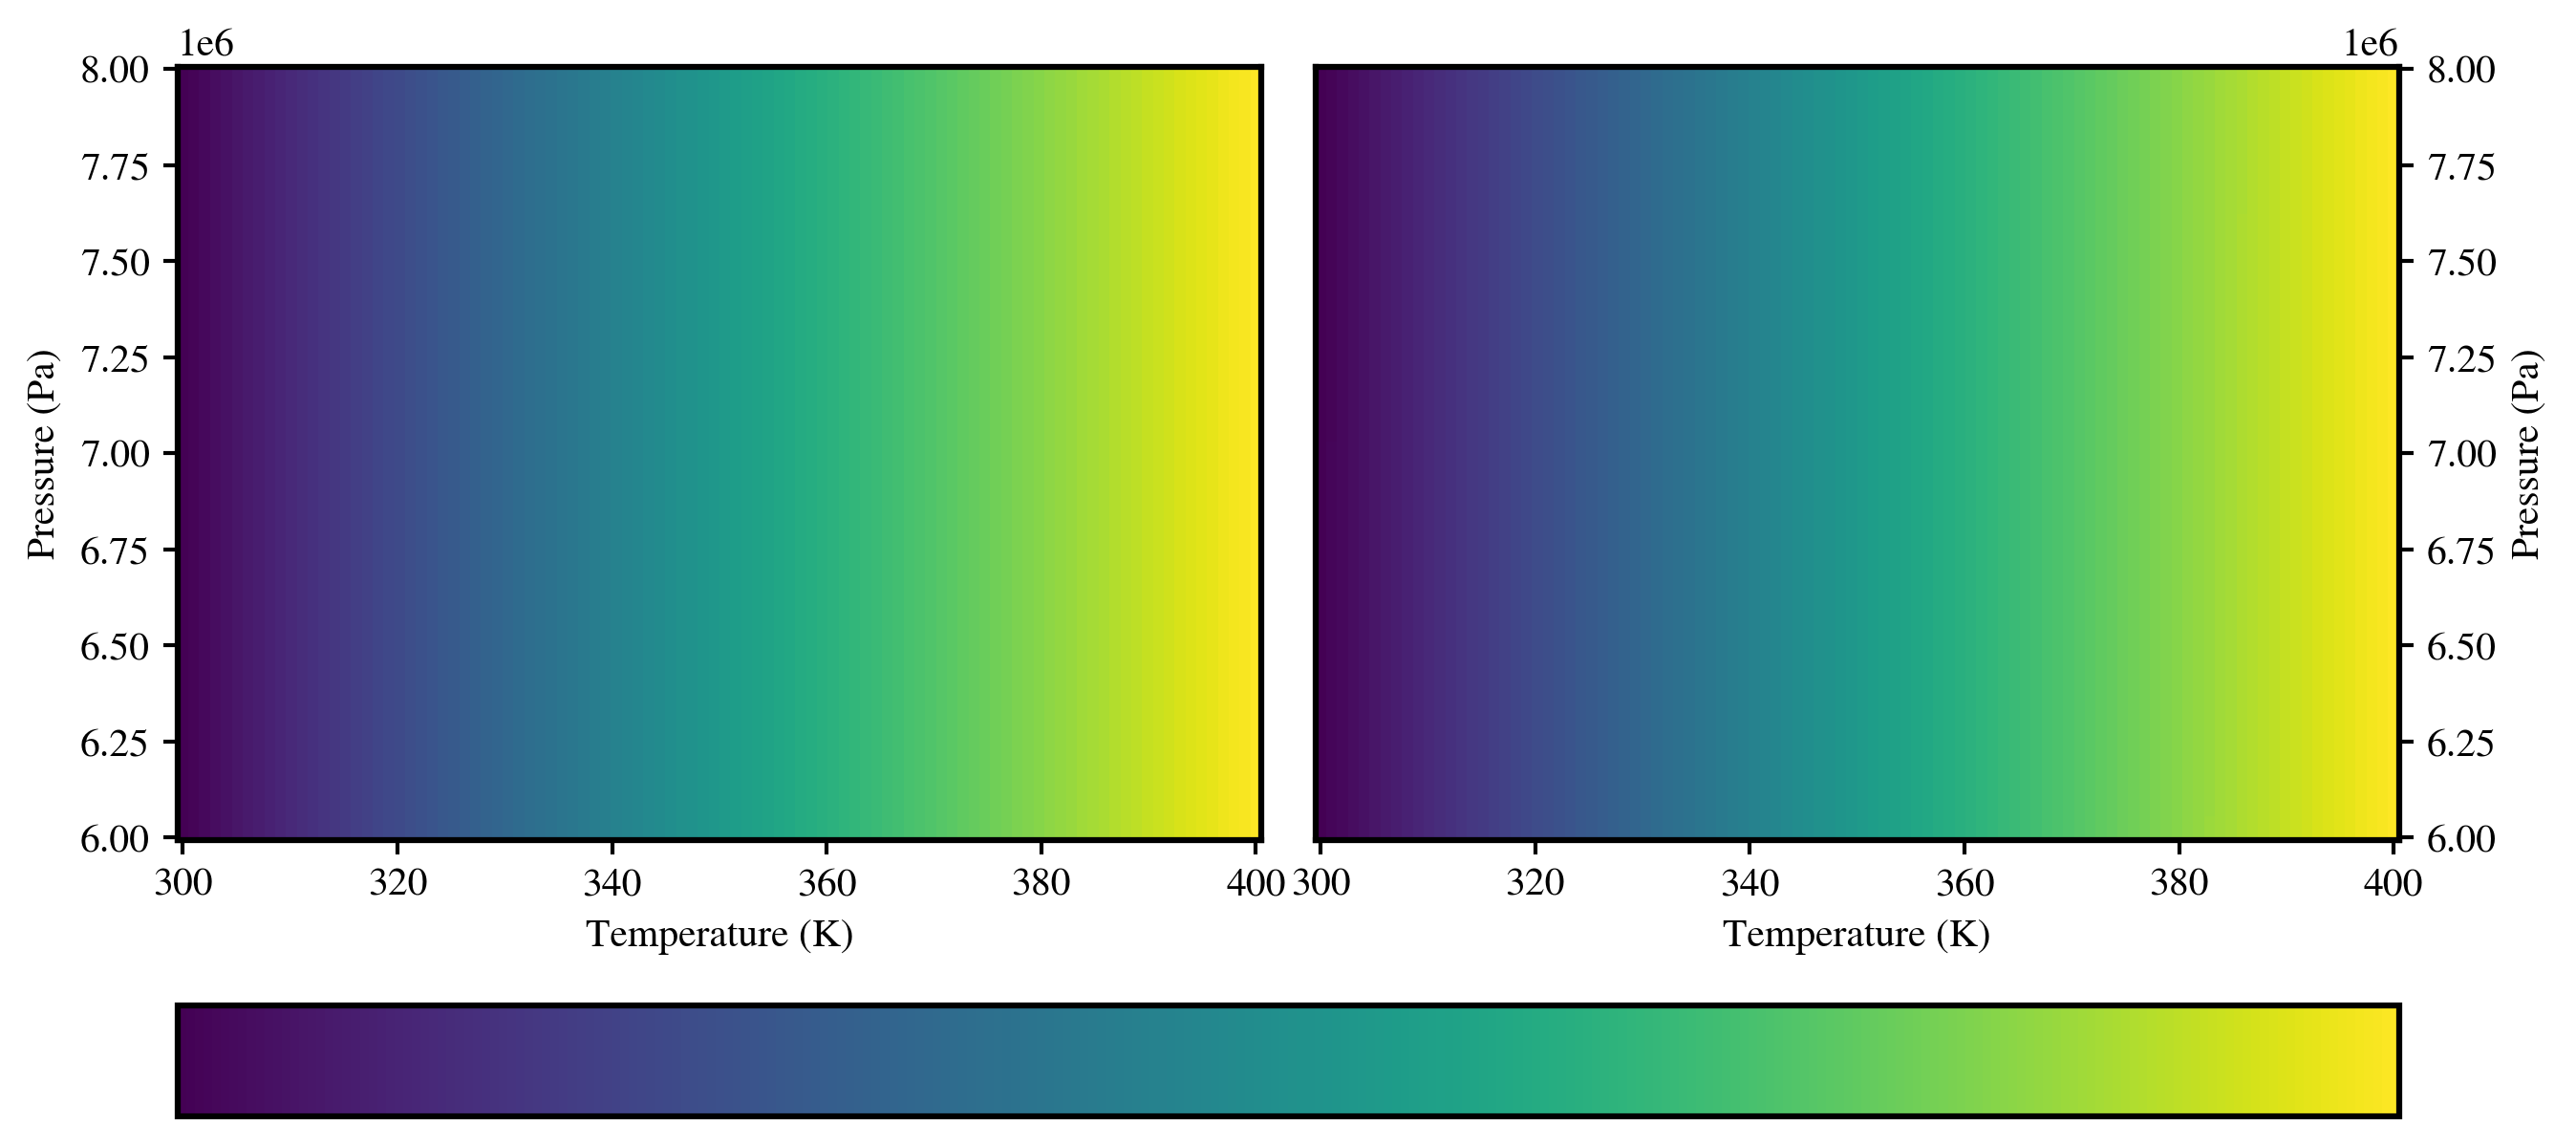

In [29]:
fig = plt.figure(figsize = [10, 5])
ax1 = fig.add_subplot(1, 2, 1)
ax1.pcolormesh(T, P, jnp.log(F1))
ax1.set_xlabel("Temperature (K)")
ax1.set_ylabel("Pressure (Pa)")
ax1.yaxis.set_label_position("left")
ax1.yaxis.tick_left()

ax2 = fig.add_subplot(1, 2, 2)
c = ax2.pcolormesh(T, P, jnp.log(F2))
ax2.set_xlabel("Temperature (K)")
ax2.set_ylabel("Pressure (Pa)")
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()

plt.subplots_adjust(wspace = 0.05)

fig.colorbar(c, location = 'bottom', ax = [ax1, ax2], ticks  = [])